# Setup

In [47]:
# imports
from dm_control import suite
from dm_control import viewer
from dm_env import StepType
import numpy as np
import matplotlib.pyplot as plt
import statistics
import time

In [48]:
# Create the environment
env = suite.load(domain_name='cartpole', task_name='swingup')
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
  #del time_step  # Unused.
  return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)


# Launch the viewer application.
viewer.launch(env, policy=random_policy)

## Observationspace

`env.step(action)` returns a timestep containing 4 variables:
- Type of timestep (first, mid, last)
- reward (between 1 and 0)
- discount
- observation containing of 2 parts (position and velocity)

In [49]:
action = 1
timestep, reward, discount, observation = env.step(action)
observation

OrderedDict([('position', array([-0.06771985, -0.99400051,  0.10937543])),
             ('velocity', array([-0.15947001,  0.18761225]))])

The observation consist of a position dict with
- Position of the cart
- Cosin of the pole angle
- Sin of the pole angle

and a velcity dict with
- $\dot{x}$: speed of the cart
- $\dot{\theta}$: angular velocity of the pole


The output of `env.physics.get_state()` is
- x: position of the cart
- $\theta$: angle of the pole, 0 in the upright position
- $\dot{x}$: speed of the cart
- $\dot{\theta}$: angular velocity of the pole

## Actionspace

In [50]:
# Actionspace
action_space = env.action_spec()
action_space

BoundedArray(shape=(1,), dtype=dtype('float64'), name=None, minimum=[-1.], maximum=[1.])

The action consists of a force applied on the cart. The action needs to be between -1 and 1 and is continuous. As noted in the `cartpole.xml` file, the gear of the actuator is 10. This means that force applied is the $action * 10$. Thus the force applied is between -10 and 10N.

# Model
## Analytical Solution
The Cart-Pole problem is a classic control theory problem used to test reinforcement learning algorithms. It involves balancing a pole, hinged to a cart, by moving the cart horizontally. The objective is to keep the pole upright for as long as possible without letting it fall or the cart moving out of the defined boundaries.

To describe the Cart-Pole problem mathematically, we need to define the state variables, control input, and the equations of motion.


### State variables
The state of the system at any given time can be represented by a 4-dimensional vector:

$s(t) = [x(t), \dot{x}(t), \theta(t), \dot{\theta}(t)]$

where:
- $x(t)$ position of the cart at time t
- $\dot{x}(t)$ velocity of the cart at time t
- $\theta(t)$ angle of the pole with the vertical axis at time t
- $\dot{\theta}(t)$ angular velocity of the pole at time t

### Control input
The control input is the horizontal force applied to the cart using an actuator:

$u(t) = F$

where F is the force applied to the cart, and it can be positive (to the right) or negative (to the left).

### Discrete time
Update the position and velocity of the cart:

$x[t+1] = x[t] + \dot{x}[t] * \Delta t$

$\dot{x}[t+1] = \dot{x}[t] + \ddot{x}[t] * \Delta t$

Update the angle and angular velocity of the pole:

$\theta[t+1] = \theta[t] + \dot{\theta}[t] * \Delta t$

$\dot{\theta}[t+1] = \dot{\theta}[t] + \ddot{\theta}[t] * \Delta t$

In [51]:
# values from cartpole.xml
dt = 0.01
g = 9.81
m_c = 1
m_p = 0.1
l = 0.5
d_c = 5e-4
d_p = 2e-6
gear = 10 # from input to force in Newton

In [52]:
# insert of the dynaical equations
def cartpole_derivatives(state, F, m_c, m_p, l, g): # F * 10 to 
    x, x_dot, theta, theta_dot = state

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    theta_double_dot = (g * sin_theta + cos_theta * (-F - m_p * l * theta_dot**2 * sin_theta + d_c * np.sign(x_dot))/(m_c + m_p) - (d_p * theta_dot)/(m_p * l)) / (l * (4/3 - (m_p * cos_theta**2)/(m_c + m_p)))
    x_double_dot = (F + m_p * l * (theta_dot**2 * sin_theta - theta_double_dot * cos_theta) - d_c * np.sign(x_dot))/(m_c + m_p)
    
    return np.array([x_dot, x_double_dot, theta_dot, theta_double_dot])

def euler_step(state, F, m_c, m_p, l, g, dt):
    derivatives = cartpole_derivatives(state, F*gear, m_c, m_p, l, g) # gear 10 the adjust the force to Newton
    new_state = state + dt * derivatives
    return new_state

def rk4_step(state, F, m_c, m_p, l, g, dt):
    F = F * gear # gear 10 the adjust the force to Newton
    k1 = cartpole_derivatives(state, F, m_c, m_p, l, g )
    k2 = cartpole_derivatives(state + 0.5 * dt * k1, F, m_c, m_p, l, g)
    k3 = cartpole_derivatives(state + 0.5 * dt * k2, F, m_c, m_p, l, g)
    k4 = cartpole_derivatives(state + dt * k3, F, m_c, m_p, l, g)

    new_state = state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state

### Comparison of model and environement

startstate [-1.02745453e-03  4.18490485e-03  3.14906405e+00 -3.49081246e-03]

env  [-1.27334566e-03 -5.33625640e-02  3.14860596e+00 -8.81153380e-02]
euler  [-9.85605483e-04 -5.35038201e-02  3.14902914e+00 -9.11208886e-02]
rk4  [-1.27401360e-03 -5.34945355e-02  3.14859111e+00 -9.10829821e-02]

env  [-0.03406463 -0.44107456  3.05313188 -0.74245929]
euler  [-0.03204563 -0.44309197  3.05264486 -0.78691534]
rk4  [-0.03426914 -0.44217778  3.0489226  -0.76745646]

env  [-0.21243408 -0.41802513  3.02283417  0.44467377]
euler  [-0.21047797 -0.41506585  3.01682189  0.50712749]
rk4  [-0.21220169 -0.41598401  3.02733887  0.48606285]

env  [-0.29677267 -0.00346595  3.39158335  0.431531  ]
euler  [-0.29526993 -0.00352308  3.41931382  0.42526499]
rk4  [-0.29620299 -0.005417    3.40098888  0.38020414]

env  [-0.12890265  0.04314135  3.32218937 -1.57913165]
euler  [-0.12968533  0.03491782  3.309824   -1.76615513]
rk4  [-0.12971802  0.03967106  3.29736773 -1.65445006]

env  [-0.23863188 -0.4261084   2.5

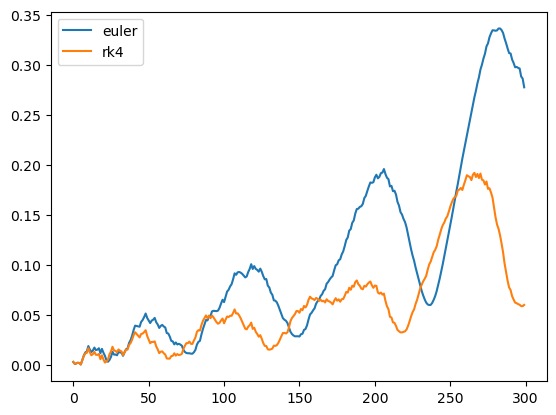

In [57]:
# compare dynamical equations and RK with euler
# the different dynamical equations need to be copy-pasted into the cartpole_derivatives function
F = -0.1
env.reset()

real_state = env.physics.get_state()
start_state = np.array([real_state[0],real_state[2],real_state[1],real_state[3]]) #reorder to same order as cartpole derivatives
euler_state = start_state
rk4_state = start_state

euler_error = []
rk4_error = []

print('startstate', start_state)
print()
for i in range(300):
    F = np.random.uniform(low=action_spec.minimum, high=action_spec.maximum, size=action_spec.shape)[0]
    env.step(F)
    env_state = env.physics.get_state()
    env_state = np.array([env_state[0],env_state[2],env_state[1],env_state[3]])
    euler_state = euler_step(euler_state, F, m_c, m_p, l, g, dt)
    rk4_state = rk4_step(rk4_state, F, m_c, m_p, l, g, dt)
    if i%50 == 0: # print every 10th timestep    
        print('env ', env_state)
        print('euler ', euler_state)
        print('rk4 ', rk4_state)
        print()
    euler_error.append(np.linalg.norm(env_state - euler_state))
    rk4_error.append(np.linalg.norm(env_state - rk4_state))

plt.plot(euler_error, label='euler')   
plt.plot(rk4_error, label='rk4')
plt.legend()

developement of the combined error of euler forward and RK4 compared with the model until a timestep of 300

# Rollout

In [ ]:
# parameters
# Define the predictive sampling controller parameters
horizon = 50
num_samples = 10

# Define the weights
w_angle = 1
w_center = 0.5
w_vel = 0
w_cov = 0.1

# initalize an optimal action
opt_u = np.zeros(horizon)
cov = np.eye(horizon) * w_cov

#constraints
x_min = -1.8
x_max = 1.8

constraint_penalty = 1e8
soft_constraint_weight = 1e5
soft_constraint_margin = 0.1

In [ ]:
def rollout_theta(u, state):
    cost = 0
    theta = []

    for j in range(horizon):
        state = euler_step(state, u[j], m_c, m_p, l, g, dt) # interate through the simulation
        
        cart_position_cost = 0
        if state[0] < x_min or state[0] > x_max:
            cart_position_cost = constraint_penalty
        else:
            cart_position_margin = min(state[0] - x_min, x_max - state[0])
            if cart_position_margin < soft_constraint_margin:
                cart_position_cost = soft_constraint_weight * (soft_constraint_margin - cart_position_margin)
        
        cost += 1**j * (w_angle * (1 - np.cos(state[2])) + w_center * (state[0])**2 + w_vel * (state[3])**2 + cart_position_cost)  # sum the cost
        theta.append(state[2])
    return cost, theta

## Check the improvement of theta when refining u

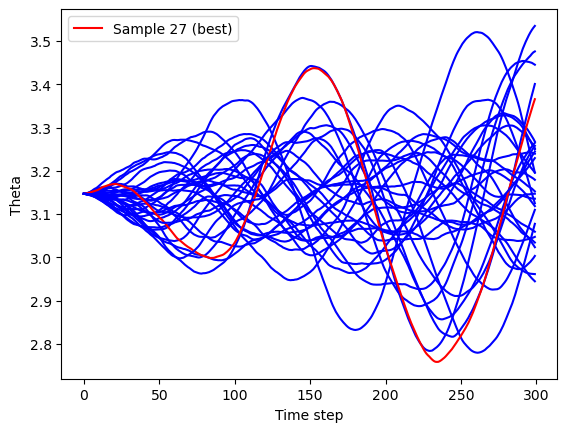

In [ ]:
# development of theta, first sampling
horizon = 300
num_samples = 30
w_cov = 0.1
cov = np.eye(horizon) * w_cov

timestep, reward, discount, observation = env.reset()

opt_u = np.zeros(horizon)
#opt_u = np.ones(horizon)*-1

u = np.random.multivariate_normal(opt_u, cov, num_samples) 
u = np.clip(u,-1,1)

# save the state of the environment and create a copy to simulate in
real_state = env.physics.get_state()[[0, 2, 1, 3]] # adjust the order to x, xdot, theta, thetadot

# calculate rollouts and cost
temp = [rollout_theta(u[i], real_state) for i in range(num_samples)]
cost = [t[0] for t in temp]
theta = [t[1] for t in temp]

# Choose the control input with the lowest cost
best_index = np.argmin(cost)
opt_u = u[best_index]
theta_collection = [theta[best_index]]

# Plot the angles
best_color = 'red'
non_best_color = 'blue'

for i, angles in enumerate(theta):
    if i == best_index:
        plt.plot(angles, color=best_color, linestyle='-', label=f'Sample {i} (best)')
    else:
        plt.plot(angles, color=non_best_color, linestyle='-')

plt.xlabel('Time step')
plt.ylabel('Theta')
plt.legend()
plt.show()

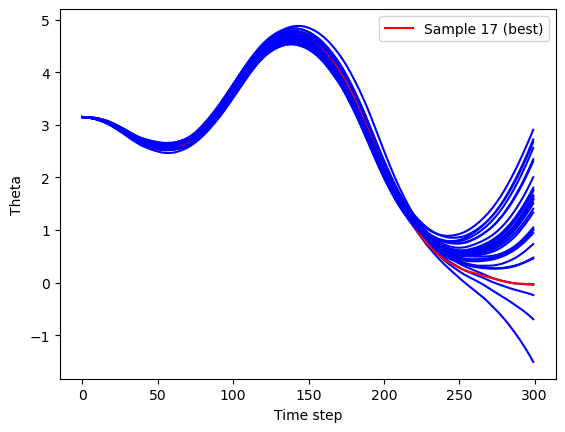

In [ ]:
# improve to standing upright after X iterations
theta_collection = []
horizon = 300
for i in range(300):
    u = np.random.multivariate_normal(opt_u, cov, num_samples-1) 
    u = np.concatenate((opt_u[np.newaxis, :], u), axis=0) # add opt_u to the new samples
    u = np.clip(u,-1,1)

    # save the state of the environment and create a copy to simulate in
    real_state = env.physics.get_state()[[0, 2, 1, 3]] # adjust the order to x, xdot, theta, thetadot

    # calculate rollouts and cost
    temp = [rollout_theta(u[i], real_state) for i in range(num_samples)]
    cost = [t[0] for t in temp]
    theta = [t[1] for t in temp]

    # Choose the control input with the lowest cost
    best_index = np.argmin(cost)
    opt_u = u[best_index]
    theta_collection.append(theta[best_index])

# Plot the angles
best_color = 'red'
non_best_color = 'blue'

for i, angles in enumerate(theta):
    if i == best_index:
        plt.plot(angles, color=best_color, linestyle='-', label=f'Sample {i} (best)')
    else:
        plt.plot(angles, color=non_best_color, linestyle='-')

plt.xlabel('Time step')
plt.ylabel('Theta')
plt.legend()
plt.show()

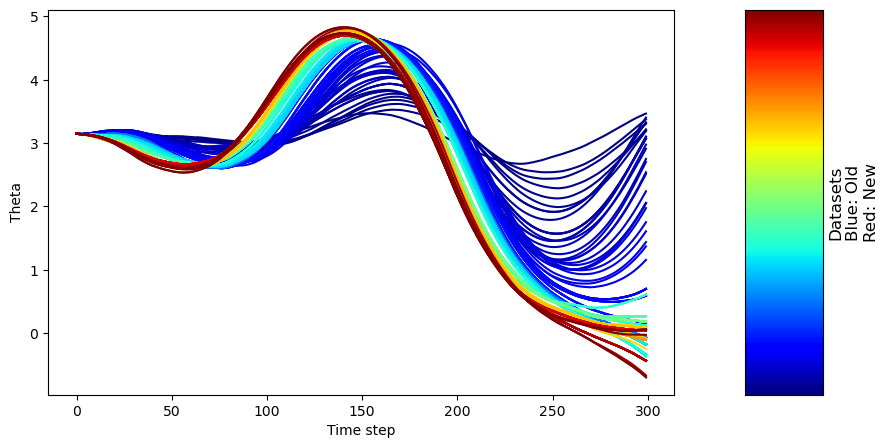

In [ ]:
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

num_datasets = len(theta_collection)
# Choose a colormap
colormap = cm.jet

# Normalize the dataset indices to the range of 0-1 for the colormap
norm = Normalize(0, num_datasets - 1)

# Create a meshgrid with y values corresponding to dataset indices
Y = np.array([[i] * 2 for i in range(num_datasets)])
X = np.array([[0, 1]])

# Plot each dataset with a slightly different color
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [8, 1]})

for i, data in enumerate(theta_collection):
    ax1.plot(data, color=colormap(norm(i)))

# Plot the colorbar
colorbar = ax2.pcolormesh(X, Y, Y, cmap=colormap, shading='auto')

# Set colorbar limits and orientation
colorbar.set_clim(0, num_datasets - 1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('Datasets\nBlue: Old\nRed: New', fontsize=12)
ax2.yaxis.set_label_position("right")

ax1.set_xlabel('Time step')
ax1.set_ylabel('Theta')
plt.show()


# Stripped code

In [ ]:
env = suite.load(domain_name='cartpole', task_name='swingup')

action_spec = env.action_spec()

# physics from cartpole.xml
dt = 0.01
g = 9.81
m_c = 1
m_p = 0.1
l = 0.5
d_c = 5e-4
d_p = 2e-6
gear = 10 # from input to force in Newton

# weights and parameters
w_angle = 1
w_cov = 0.05
w_center = 1
num_samples = 20
horizon = 100

# initalize an optimal action
opt_u = np.zeros(horizon)
cov = np.eye(horizon) * w_cov

def cartpole_derivatives(state, F, m_c, m_p, l, g): # F * 10 to 
    x, x_dot, theta, theta_dot = state

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    theta_double_dot = (g * sin_theta + cos_theta * (-F - m_p * l * theta_dot**2 * sin_theta + d_c * np.sign(x_dot))/(m_c + m_p) - (d_p * theta_dot)/(m_p * l)) / (l * (4/3 - (m_p * cos_theta**2)/(m_c + m_p)))
    x_double_dot = (F + m_p * l * (theta_dot**2 * sin_theta - theta_double_dot * cos_theta) - d_c * np.sign(x_dot))/(m_c + m_p)
    
    return np.array([x_dot, x_double_dot, theta_dot, theta_double_dot])

def euler_step(state, F, m_c, m_p, l, g, dt):
    derivatives = cartpole_derivatives(state, F*gear, m_c, m_p, l, g) # gear 10 the adjust the force to Newton
    new_state = state + dt * derivatives
    return new_state

def rollout(u, state):
    cost = 0

    for j in range(horizon):
        state = euler_step(state, u[j], m_c, m_p, l, g, dt) # interate through the simulation
        
        cost += (w_angle * (1 - np.cos(state[2])) + w_center * (state[0])**2)  # sum the cost
    return cost

# Policy
def predictiv_sampling_policy(time_step):
  
  # sample control inputs
  global opt_u 
  opt_u = np.delete(opt_u, 0) # Remove the first element
  opt_u = np.append(opt_u, opt_u[-1]) # Duplicate the last element
  
  u = np.random.multivariate_normal(opt_u, cov, num_samples-1) 
  u = np.concatenate((opt_u[np.newaxis, :], u), axis=0) # add opt_u to the new samples
  u = np.clip(u,-1,1)

  # save the state of the environment and create a copy to simulate in
  real_state = env.physics.get_state()[[0, 2, 1, 3]] # adjust the order to x, xdot, theta, thetadot
  
  # calculate rollouts and cost
  cost = [rollout(u[i], real_state) for i in range(num_samples)]
    
  # Choose the control input with the lowest cost
  best_index = np.argmin(cost)
  opt_u = u[best_index]
    
  return opt_u[0] # return the first element of the optimal control input

In [ ]:
env = suite.load(domain_name='cartpole', task_name='swingup')
# Launch the viewer application.
viewer.launch(env, policy=predictiv_sampling_policy)

# Generating results
## Balance

In [ ]:
# Test
env = suite.load(domain_name='cartpole', task_name='balance')

# Test
test_episodes = 30
test_scores = []
test_rewards = []
start_time = time.time()


for e in range(test_episodes):
    time_step = env.reset()
    sum_rewards = 0

    for t in range(1000): # 1000 steps (half delta t of gym)
        action = predictiv_sampling_policy(time)
        time_step = env.step(action)
        timestep, reward, discount, observation = time_step
        sum_rewards += reward
    

        if observation['position'][1] < 0.978 or timestep == StepType.LAST or t == 999 : # cos of angle < cos of 12 degrees--> angle > 12deg or 1000 steps (half delta t of gym) 
            print("Test Episode: {}/{}, Score: {}".format(e + 1, test_episodes, t))
            test_scores.append(t)
            test_rewards.append(sum_rewards)
            break

test_average = statistics.mean(test_scores)
test_sigma = statistics.stdev(test_scores)
reward_average = statistics.mean(test_rewards)
reward_sigma = statistics.stdev(test_rewards)
end_time = time.time()
total_time = end_time - start_time
total_steps = sum(test_scores)
average_time_per_step = total_time / total_steps

print()
print('Score average: {:.2f}, Sigma: {:.2f}'.format(test_average, test_sigma))
print('Average time per step: {:.4f} seconds'.format(average_time_per_step))
print('Reward average: {:.2f}, Sigma: {:.2f}'.format(reward_average, reward_sigma))

env.close()

Test Episode: 1/30, Score: 999
Test Episode: 2/30, Score: 999
Test Episode: 3/30, Score: 999
Test Episode: 4/30, Score: 999
Test Episode: 5/30, Score: 999
Test Episode: 6/30, Score: 999
Test Episode: 7/30, Score: 999
Test Episode: 8/30, Score: 999
Test Episode: 9/30, Score: 999
Test Episode: 10/30, Score: 999
Test Episode: 11/30, Score: 999
Test Episode: 12/30, Score: 999
Test Episode: 13/30, Score: 999
Test Episode: 14/30, Score: 999
Test Episode: 15/30, Score: 999
Test Episode: 16/30, Score: 999
Test Episode: 17/30, Score: 999
Test Episode: 18/30, Score: 999
Test Episode: 19/30, Score: 999
Test Episode: 20/30, Score: 999
Test Episode: 21/30, Score: 999
Test Episode: 22/30, Score: 999
Test Episode: 23/30, Score: 999
Test Episode: 24/30, Score: 999
Test Episode: 25/30, Score: 999
Test Episode: 26/30, Score: 999
Test Episode: 27/30, Score: 999
Test Episode: 28/30, Score: 999
Test Episode: 29/30, Score: 999
Test Episode: 30/30, Score: 999

Score average: 999.00, Sigma: 0.00
Average time 

In [ ]:
# Test
env = suite.load(domain_name='cartpole', task_name='swingup')


# Test
test_episodes = 30
test_rewards = []
start_time = time.time()


for e in range(test_episodes):
    time_step = env.reset()
    sum_rewards = 0

    for t in range(1000): # 10s
        action = predictiv_sampling_policy(time)
        time_step = env.step(action)
        timestep, reward, discount, observation = time_step
        sum_rewards += reward
    

    test_rewards.append(sum_rewards)


reward_average = statistics.mean(test_rewards)
reward_sigma = statistics.stdev(test_rewards)
end_time = time.time()
total_time = end_time - start_time
average_time_per_step = total_time / (test_episodes * 1000)

print()
print('Reward average: {:.2f}, Sigma: {:.2f}'.format(reward_average, reward_sigma))
print('Average time per step: {:.4f} seconds'.format(average_time_per_step))

env.close()


Reward average: 740.93, Sigma: 3.92
Average time per step: 0.0142 seconds
